# Coupon collector's problem (Sammelbilderproblem)

Lets try to simulate it first (with good old random.randint()):

In [1]:
%matplotlib inline

import numpy
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
images = 25
total_rounds = 1000000

set_counter = numpy.zeros(images + 1)
every_attempt = numpy.zeros(total_rounds, dtype=numpy.int_)

for i in range(1, total_rounds + 1):
    attempt = 0
    filled = False
    num_filled = 0
    
    while not num_filled == images:
        attempt += 1 
        n = numpy.random.randint(low=1, high=images+1)
        if set_counter[n] == i - 1:
            set_counter[n] = i
            num_filled += 1

    every_attempt[i-1] = attempt

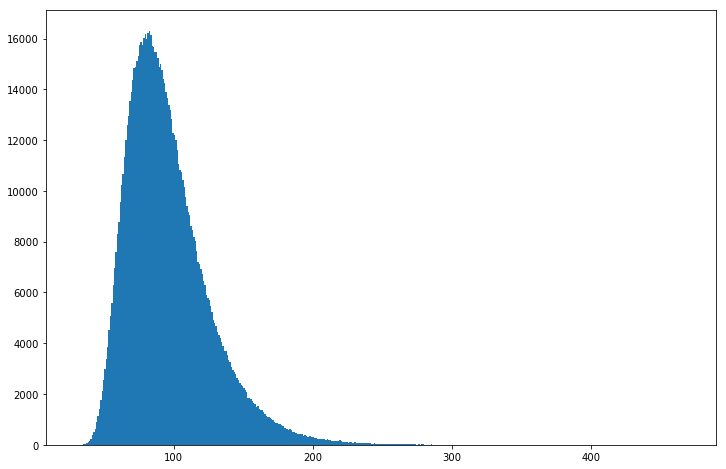

In [3]:
n, _, _ = plt.hist(every_attempt, bins=range(min(every_attempt), max(every_attempt)), label="attempts")

In [4]:
print("When collecting", images, "images in a set, simulating", total_rounds, "tries:")
print("The average number tries to get all is", numpy.mean(every_attempt), "images.")
print("the 95 percentile is", numpy.percentile(every_attempt, 95), "images,")
print("the minimum is", numpy.min(every_attempt), "images,")
print("the maximum is", numpy.max(every_attempt), "images.")

When collecting 25 images in a set, simulating 1000000 tries:
The average number tries to get all is 95.423529 images.
the 95 percentile is 152.0 images,
the minimum is 30 images,
the maximum is 469 images.


## Now with theory

First we calculate the theoretical mean:

In [5]:
sum = 0
n = images
for i in range(1,n):
    sum += 1/i
sum *= n

print("The theoretical mean to collect a set of", n, "images is", sum, "images.")

The theoretical mean to collect a set of 25 images is 94.39895444383767 images.


Then we calculate the theoretical distribution, source is
http://nibis.de/~lbs-gym/Verschiedenespdf/vollstaendigeSerie.pdf

In [7]:
import math
import scipy.special

n = images
max_tries = max(every_attempt)
hist = numpy.zeros(max_tries+1)

for k in range(1,max_tries):
    sum = 0
    for r in range(1,n):
        sum += math.pow(-1, r-1) * scipy.special.binom(n, r) * math.pow(1-r/n, k) * r / n
    
    hist[k] = sum

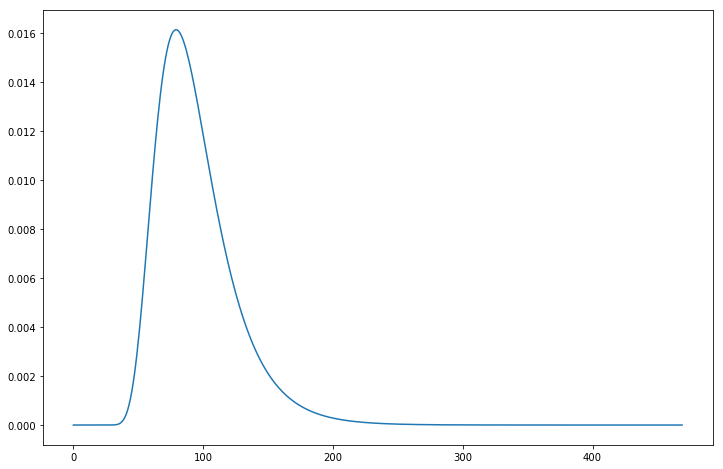

In [8]:
_ = plt.plot(range(max_tries+1), hist)